# Sales Forecasting<a id="Top"></a>

## Table of Contents

1. [Load Needed Packages](#1)<br>
2. [Get Data](#2)<br>
    2.1 [Read in the Data from csv](#2.1)<br>
    2.2 [Clean Data](#2.2)<br>
    2.3 [Preprocess Data](#2.3)<br>
3. [Explore Data](#3)<br>
    3.1 [Data Correlation](#3.1)<br>
    3.2 [Data Visualization](#3.2)<br>
4. [Analysis](#4)<br>
    4.1 [Linear Regression in SKLearn](#4.1)<br>
    4.2 [Linear Regression in Statsmodels](#4.2)<br>
    4.3 [Regression Tree in Decision Tree](#4.3)<br>
    4.4 [Regression Tree in Random Forests](#4.4)<br>
5. [Compare Mode](#5)<br>

---
## 1. Load Needed Packages<a id=1></a>

In [1]:
# !pip install sklearn --upgrade
# !pip install statsmodels --upgrade
# !pip install eli5 --upgrade

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Linear Regression in SKLearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Calculate the Feature Importance
import eli5
from eli5.sklearn import PermutationImportance

# Linear Regression in Statsmodels
import statsmodels.api as sm
from scipy import stats

# Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

# Random Forest
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

##### [Back to Top](#Top)

---
## 2. Get Data<a id=2></a>

### 2.1 Read in the Data from csv<a id=2.1></a>
Data Source: https://www.kaggle.com/manjeetsingh/retaildataset

In [3]:
features = pd.read_csv('data/retail_features_data.csv')
sales = pd.read_csv('data/retail_sales_data.csv')
stores = pd.read_csv('data/retail_stores_data.csv')

In [4]:
features.head(2)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True


In [5]:
sales.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True


In [6]:
stores.head(2)

,Store,Type,Size
0,1,A,151315
1,2,A,202307


In [7]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [8]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [9]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


### 2.2 Clean Data<a id=2.2></a>

In [10]:
# Replace all NaN elements from MarkDown variables with 0
MD_col = [col for col in features if col.startswith('MarkDown')]
features[MD_col] = features[MD_col].fillna(0)

In [11]:
# Convert object type Date to datetime type
features['Date'] = pd.to_datetime(features['Date'])
sales['Date'] = pd.to_datetime(sales['Date'])

In [12]:
# Merge three datasets into one
df = pd.merge(sales, features, on=['Store','Date', 'IsHoliday'], how='left')
df = pd.merge(df, stores, on=['Store'], how='left')

df.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-05-02,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,1,2010-12-02,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315


In [13]:
# Format column names consistently
df.rename(columns={'Weekly_Sales': 'WeeklySales', 
                                   'Fuel_Price': 'FuelPrice'}, inplace=True)

### 2.3 Preprocess Data<a id=2.3></a>

In [14]:
# Print out categorical variables' values
unique_value = sorted(df['Type'].unique())
unique_value

['A', 'B', 'C']

In [15]:
# Encode categorical variables
df['Type'] = df['Type'].map(dict(A=0, B=1,C=2))

In [16]:
# Convert boolean to integer
df['IsHoliday'] = df['IsHoliday'].astype(int)

In [17]:
# Split Date variable into Year, Month, and Week variables
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week

In [18]:
# Shift column 'WeeklySales' to first position
df.insert(0, 'WeeklySales', df.pop('WeeklySales'))

In [19]:
# Check data type
df.dtypes

WeeklySales            float64
Store                    int64
Dept                     int64
Date            datetime64[ns]
IsHoliday                int32
Temperature            float64
FuelPrice              float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                     int64
Size                     int64
Year                     int64
Month                    int64
Week                    UInt32
dtype: object

In [20]:
# Convert UInt32 Week to Int32
df['Week'] = df['Week'].astype(int)

In [21]:
# Generate numberic variables' descriptive statistics
df.describe()

,WeeklySales,Store,Dept,IsHoliday,Temperature,FuelPrice,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Month,Week
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,15981.258123,22.200546,44.260317,0.070358,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,0.589912,136727.915739,2010.968591,6.478580,26.013457
std,22711.183519,12.785297,30.492054,0.255750,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,0.666337,60980.583328,0.796876,3.324757,14.525832
min,-4988.940000,1.000000,1.000000,0.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,0.000000,34875.000000,2010.000000,1.000000,1.000000
25%,2079.650000,11.000000,18.000000,0.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,0.000000,93638.000000,2010.000000,4.000000,14.000000
50%,7612.030000,22.000000,37.000000,0.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,0.000000,140167.000000,2011.000000,6.000000,26.000000
75%,20205.852500,33.000000,74.000000,0.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,1.000000,202505.000000,2012.000000,9.000000,38.000000
max,693099.360000,45.000000,99.000000,1.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,2.000000,219622.000000,2012.000000,12.000000,52.000000


In [22]:
# Shorten long numbers
df['WeeklySales($M)'] = df['WeeklySales']/1000000

##### [Back to Top](#Top)

---
## 3. Explore Data<a id=3></a>

### 3.1 Data Correlation<a id=3.1></a>

<AxesSubplot:>

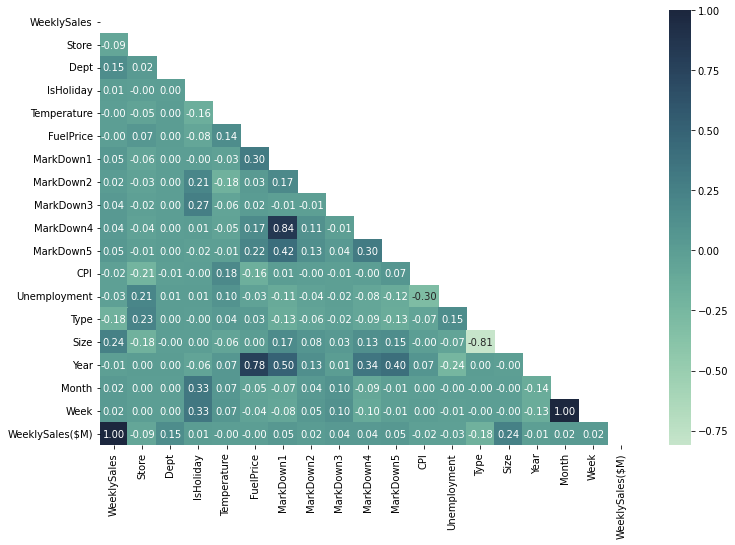

In [23]:
# Set size of figure
fig = plt.figure(figsize=(12,8))

# Creat mask
mask = np.triu(np.ones_like(df.corr()))

# Generate a new colormap
cmap = sns.cubehelix_palette(rot=-.4, as_cmap=True)
 
# Plot a triangle correlation heatmap
sns.heatmap(df.corr(), cmap=cmap, annot=True, fmt=".2f", mask=mask)

### 3.2 Data Visualization<a id=3.2></a>

In [24]:
# Total weekly sales for stores
df_store = df.groupby(['Store','Date','IsHoliday'], as_index=False)['WeeklySales($M)'].sum()

# Holiday sales for stores
df_store_holiday = df_store[df_store['IsHoliday']==True]
df_store_holiday = df_store_holiday[['Store','Date','WeeklySales($M)']].drop_duplicates(ignore_index=True)

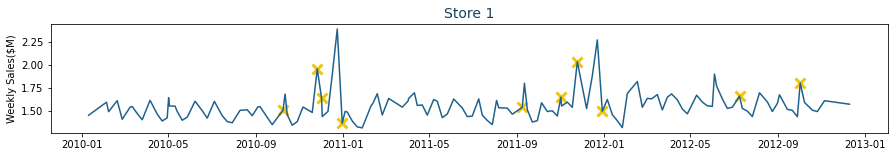

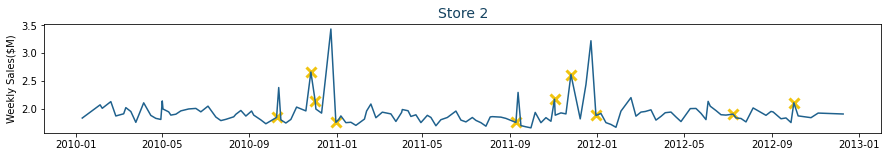

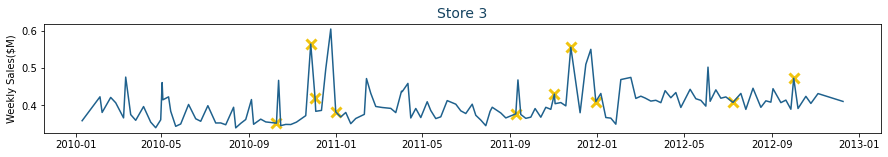

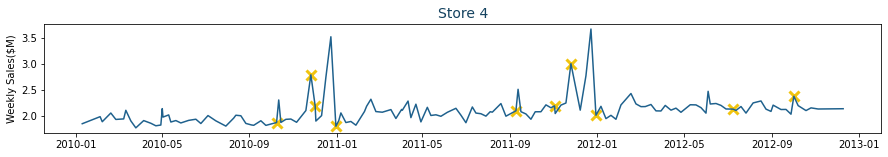

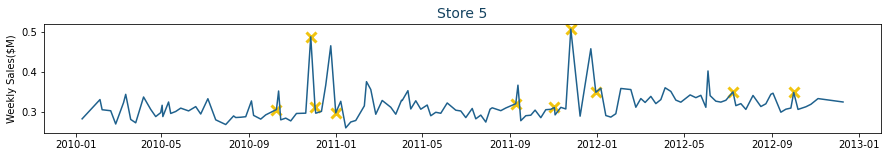

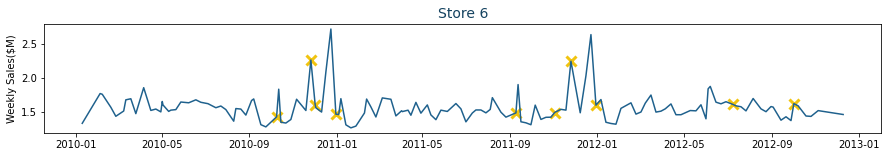

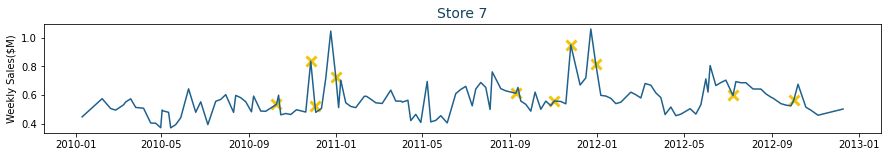

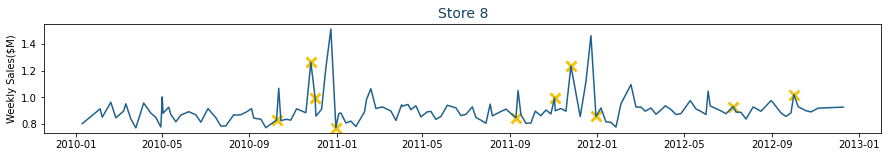

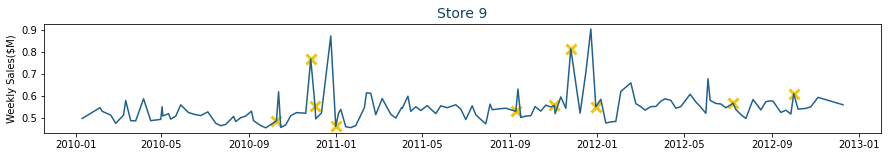

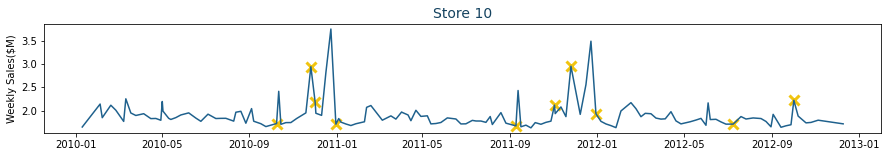

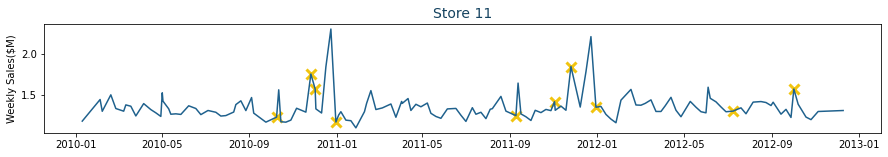

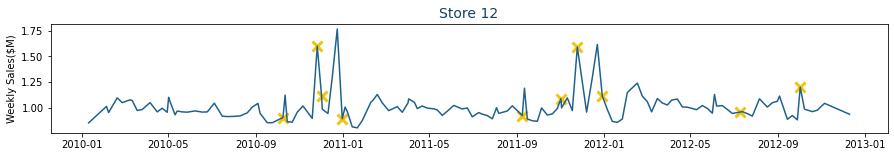

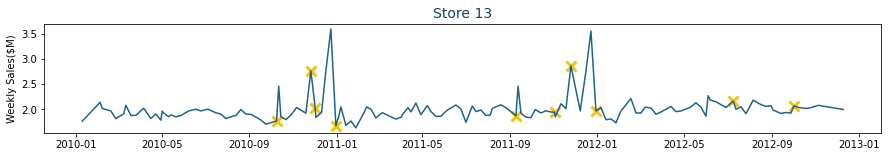

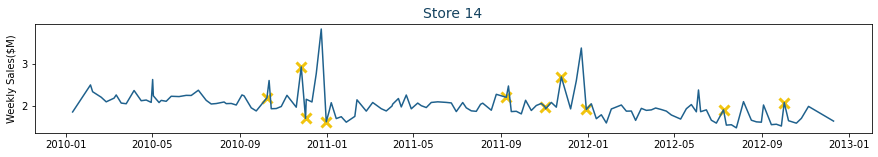

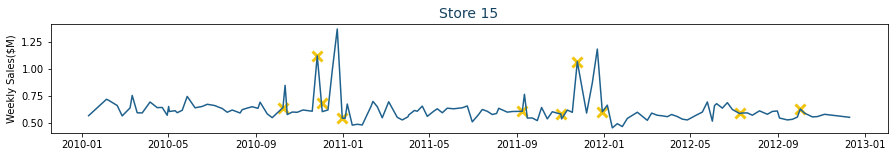

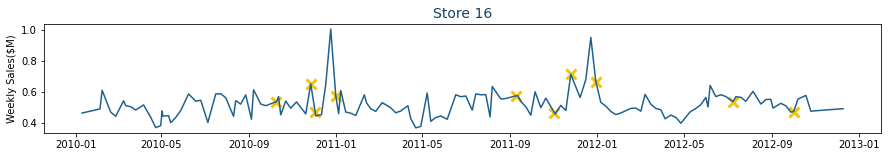

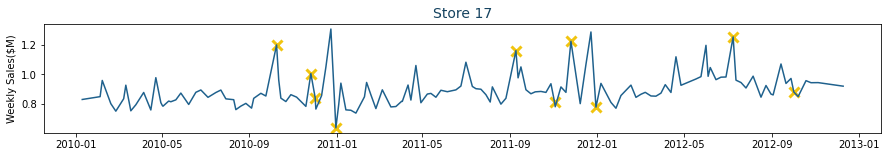

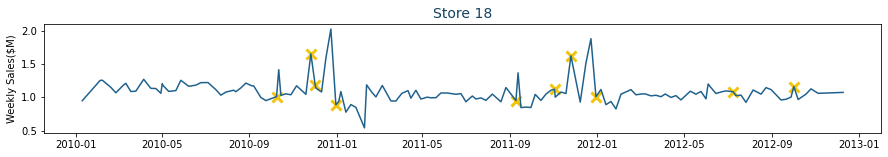

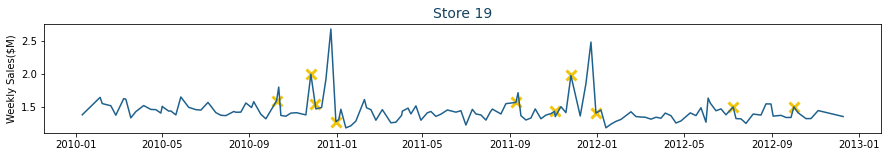

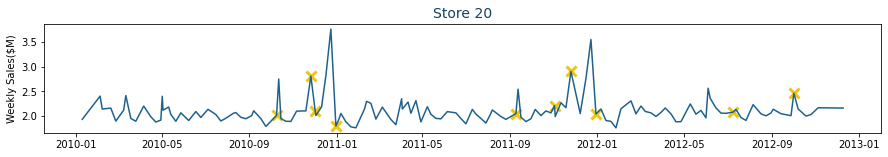

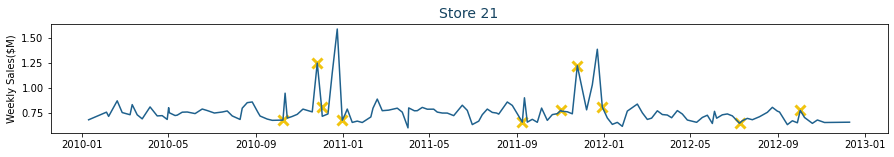

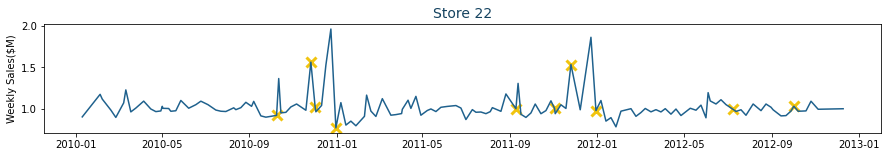

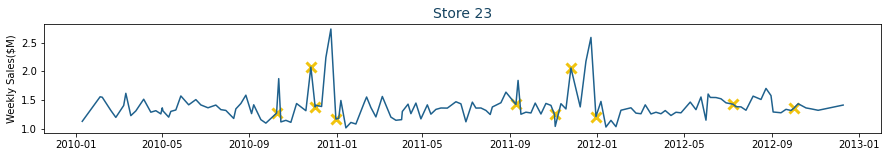

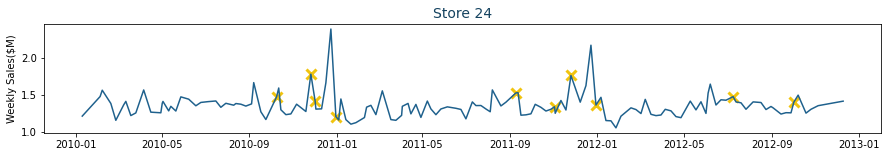

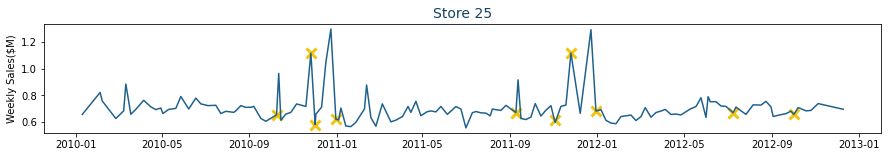

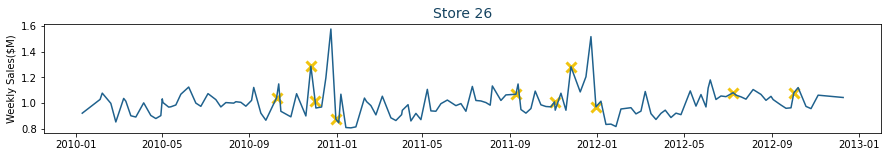

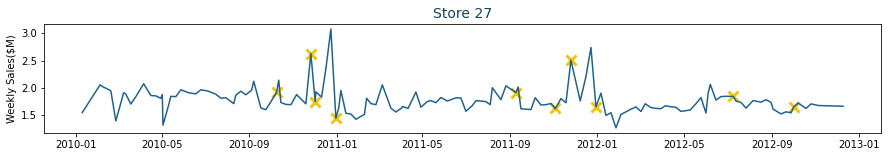

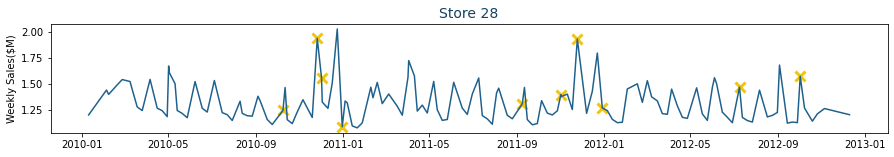

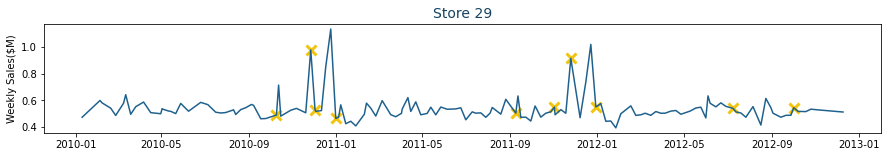

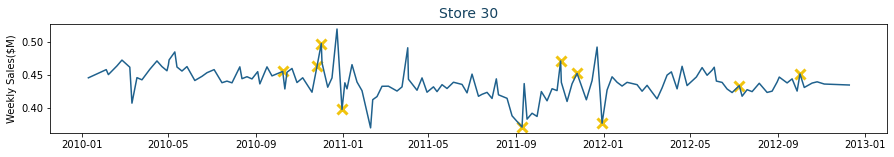

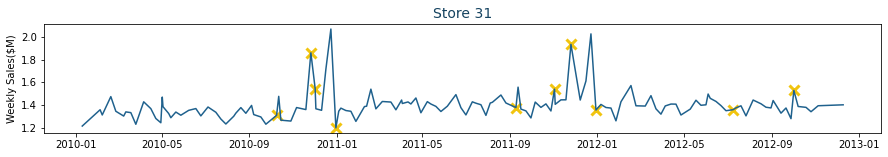

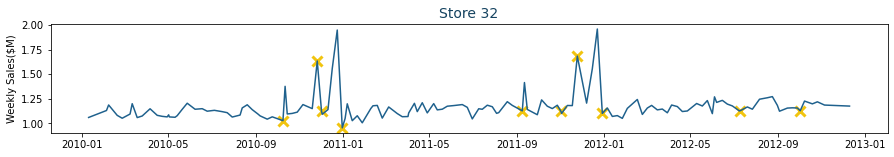

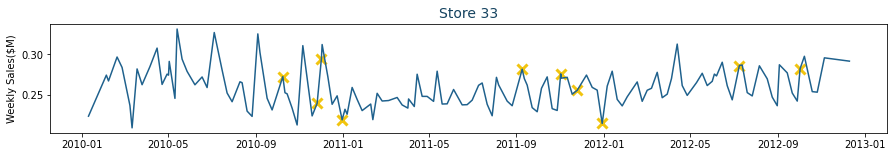

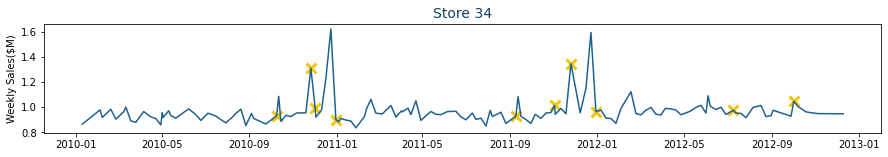

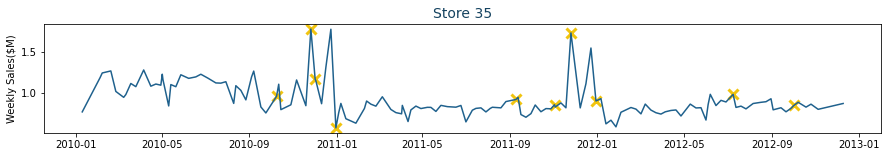

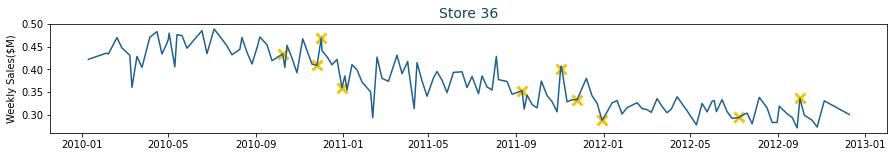

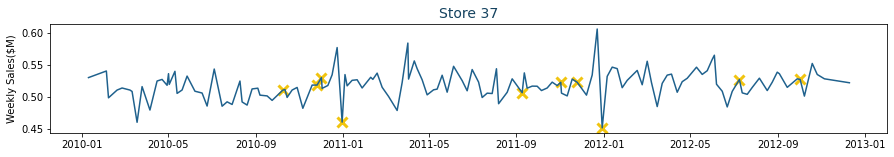

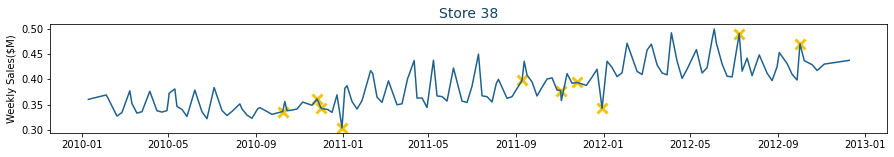

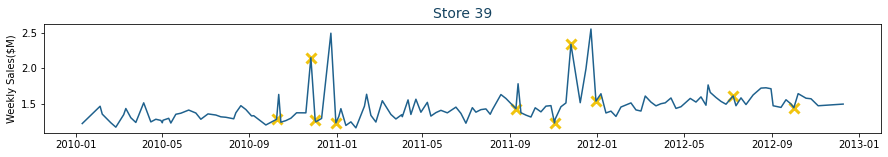

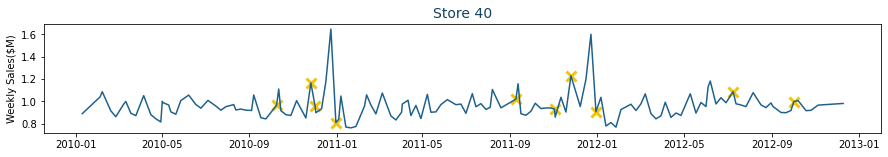

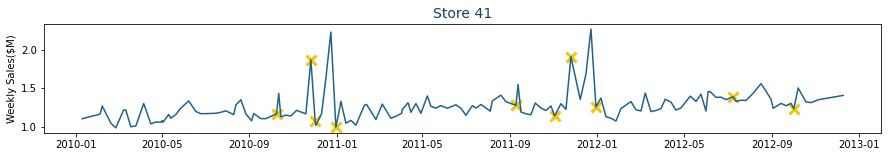

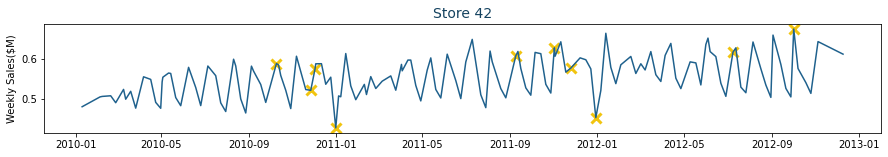

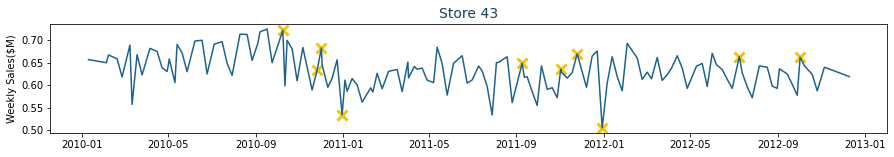

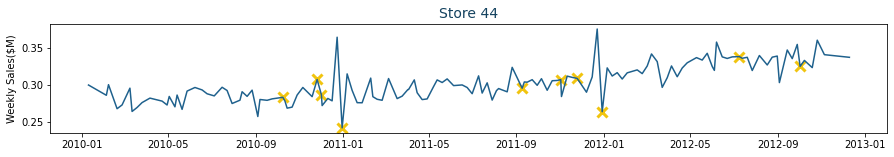

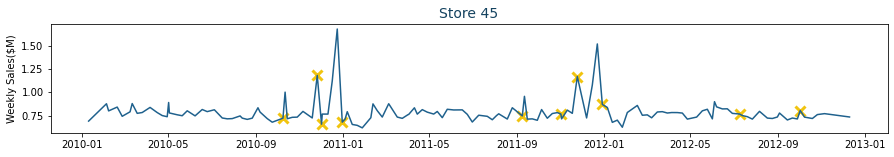

In [25]:
# All stores' id
stores_list = sorted(df_store['Store'].unique())

# Charts showing each store sales
for store in stores_list:
    plt.figure(figsize=(15,2))
    title = 'Store ' + str(store) # Chart Title
    sub_holiday = df_store_holiday[df_store_holiday['Store']==store]
    
    plt.plot('Date', 'WeeklySales($M)', data=df_store[df_store['Store']==store], color='#1F618D') # A line chart of weekly sales
    plt.scatter(sub_holiday['Date'], sub_holiday['WeeklySales($M)'], c="#F1C40F", linewidths=3, marker="x", s=100) # A scatter chart of holiday sales
    
    plt.title(title, loc='center', fontsize=14, color='#154360')
    plt.ylabel('Weekly Sales($M)')
    plt.show()

##### [Back to Top](#Top)

---
## 4. Analysis<a id=4></a>

In [26]:
# Generate a new dataset for regression
reg_df = df.copy()

# Set up a new dataset for storing predictions
pred_df = reg_df[['Store','Dept','Date','WeeklySales']]
pred_df.rename(columns={'WeeklySales':'Actual'}, inplace=True)

# Delete unneeded or improper variables
reg_df.drop(columns=['Date','WeeklySales($M)'], inplace=True)

reg_df.head(2)

,WeeklySales,Store,Dept,IsHoliday,Temperature,FuelPrice,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Month,Week
0,24924.50,1,1,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,151315,2010,5,17
1,46039.49,1,1,1,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,0,151315,2010,12,48


### 4.1 Linear Regression in SKLearn<a id=4.1></a>

In [27]:
# Define predictors
predictors = list(set(reg_df.columns) - set(['WeeklySales']))
print(predictors)

['Year', 'MarkDown5', 'Type', 'IsHoliday', 'Size', 'MarkDown4', 'Unemployment', 'Week', 'MarkDown1', 'Dept', 'MarkDown2', 'MarkDown3', 'Store', 'CPI', 'Temperature', 'FuelPrice', 'Month']


In [28]:
# Split dataset in features and target variable
y = reg_df['WeeklySales']
X = reg_df[predictors]

In [29]:
# Split 80% of the data to the training set while 20% of the data to test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Run the linear model
lm = LinearRegression()  
lm.fit(X_train, y_train)

LinearRegression()

In [30]:
# Print the coefficient value for each independent variables
lm_coef = pd.DataFrame(lm.coef_)
lm_coef.index = predictors
lm_coef.columns = ['coefficient']
lm_coef

,coefficient
Year,-786.105987
MarkDown5,0.105531
Type,1862.061518
IsHoliday,100.442561
Size,0.101465
MarkDown4,0.017645
Unemployment,-268.136095
Week,-136.986391
MarkDown1,0.019200
Dept,110.499576


In [31]:
# Calculate predicted y value based on the model created above
y_pred_lm = lm.predict(X_test)

In [32]:
# Capture the statistical measures to measure the model's performance
lm_results = pd.DataFrame({'Mean Absolute Error': metrics.mean_absolute_error(y_test, y_pred_lm),
                                               'Mean Squared Error': metrics.mean_squared_error(y_test, y_pred_lm),
                                               'Root Mean Squared Error':np.sqrt(metrics.mean_squared_error(y_test, y_pred_lm)),
                                               'R Squared':lm.score(X_test,y_test)},
                                              index=['All Features'])
lm_results

,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R Squared
All Features,14564.801098,4.687630e+08,21650.935573,0.089425


In [33]:
# Calculate the feature importance
# The features at the top are the most important, while those at the bottom are the least important
perm = PermutationImportance(lm, random_state=1).fit(X, y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.1495 ± 0.0013,Size
0.0449 ± 0.0009,Dept
0.0223 ± 0.0006,Month
0.0154 ± 0.0004,Week
0.0059 ± 0.0003,Type
0.0055 ± 0.0003,Store
0.0024 ± 0.0003,CPI
0.0015 ± 0.0002,MarkDown3
0.0014 ± 0.0001,Year
0.0009 ± 0.0002,Unemployment


In [34]:
# Drop the least important feature based on above
predictors.remove('IsHoliday')

# Split dataset in features and target variable
y = reg_df['WeeklySales']
X = reg_df[predictors]

# Split 80% of the data to the training set while 20% of the data to test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Run the linear model
lm = LinearRegression()  
lm.fit(X_train, y_train)

# Calculate predicted y value based on the model created above
y_pred_lm = lm.predict(X_test)

# Capture the statistical measures to measure the model's performance
lm_result_new = pd.DataFrame({'Mean Absolute Error': metrics.mean_absolute_error(y_test, y_pred_lm),
                                                      'Mean Squared Error': metrics.mean_squared_error(y_test, y_pred_lm),
                                                      'Root Mean Squared Error':np.sqrt(metrics.mean_squared_error(y_test, y_pred_lm)),
                                                      'R Squared':lm.score(X_test,y_test)},
                                                     index=['W/O IsHoliday'])

lm_results = lm_results.append(lm_result_new)

lm_results

,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R Squared
All Features,14564.801098,4.687630e+08,21650.935573,0.089425
W/O IsHoliday,14564.767062,4.687627e+08,21650.928173,0.089425


In [35]:
# Calculate the feature importance
# The features at the top are the most important, while those at the bottom are the least important
perm = PermutationImportance(lm, random_state=1).fit(X, y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.1490 ± 0.0012,Size
0.0445 ± 0.0010,Dept
0.0226 ± 0.0006,Month
0.0156 ± 0.0005,Week
0.0060 ± 0.0003,Type
0.0056 ± 0.0002,Store
0.0026 ± 0.0002,CPI
0.0016 ± 0.0001,MarkDown3
0.0015 ± 0.0001,Year
0.0010 ± 0.0001,Unemployment


In [36]:
# Drop the least important feature based on above
predictors.remove('MarkDown2')

# Split dataset in features and target variable
y = reg_df['WeeklySales']
X = reg_df[predictors]

# Split 80% of the data to the training set while 20% of the data to test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Run the linear model
lm = LinearRegression()  
lm.fit(X_train, y_train)

# Calculate predicted y value based on the model created above
y_pred_lm = lm.predict(X_test)

# Capture the statistical measures to measure the model's performance
lm_result_new = pd.DataFrame({'Mean Absolute Error': metrics.mean_absolute_error(y_test, y_pred_lm),
                                                      'Mean Squared Error': metrics.mean_squared_error(y_test, y_pred_lm),
                                                      'Root Mean Squared Error':np.sqrt(metrics.mean_squared_error(y_test, y_pred_lm)),
                                                      'R Squared':lm.score(X_test,y_test)},
                                                     index=['W/O MarkDown2'])

lm_results = lm_results.append(lm_result_new)

lm_results

,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R Squared
All Features,14564.801098,4.687630e+08,21650.935573,0.089425
W/O IsHoliday,14564.767062,4.687627e+08,21650.928173,0.089425
W/O MarkDown2,14564.920094,4.687682e+08,21651.055654,0.089415


<center>
    --<br>
    <strong>
        Based on the lm_results table, after the third trial, MAE, MSE, and RMSE went up and R Squared went down.<br>
        Rerun the second model, and plug the predicted values into the dataset for later comparison.
    </strong>
    <br>--
</center>

In [37]:
# Re-extract all features from the original dataset and get rid of the IsHoliday feature.
predictors = list(set(reg_df.columns) - set(['WeeklySales']))
predictors.remove('IsHoliday')

# Split dataset in features and target variable
y = reg_df['WeeklySales']
X = reg_df[predictors]

# Split 80% of the data to the training set while 20% of the data to test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Run the linear model
lm = LinearRegression()  
lm.fit(X_train, y_train)

LinearRegression()

In [38]:
# Calculate predicted y value based on the model created above
y_pred_lm = lm.predict(X)

In [39]:
# To input predictions into the dataset, check the type first
type(y_pred_lm)

numpy.ndarray

In [40]:
# Add a new column for SKLearn predictions
pred_df['SKLearn'] = y_pred_lm.tolist()

##### [Back to Top](#Top)

### 4.2 Linear Regression in Statsmodels<a id=4.2></a>

In [41]:
# Define predictors
predictors = list(set(reg_df.columns) - set(['WeeklySales']))

# Split dataset in features and target variable
y = reg_df['WeeklySales']
X = reg_df[predictors]

In [42]:
# Perform the linear regression
ols = sm.OLS(y, X).fit()
# Make the predictions by the model
predictions = ols.predict(X)

# Print out the statistics
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            WeeklySales   R-squared (uncentered):                   0.390
Model:                            OLS   Adj. R-squared (uncentered):              0.390
Method:                 Least Squares   F-statistic:                          1.583e+04
Date:                Tue, 25 Jan 2022   Prob (F-statistic):                        0.00
Time:                        00:05:57   Log-Likelihood:                     -4.8075e+06
No. Observations:              421570   AIC:                                  9.615e+06
Df Residuals:                  421553   BIC:                                  9.615e+06
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Year             1.1345      0.223      5.090      0.000       0.698       1.571
MarkDown5        0.0909      0.009     10.155      0.000       0.073       0.108
Type          1896.9879     87.752     21.618      0.000    1724.997    2068.978
IsHoliday       26.8517    148.908      0.180      0.857    -265.003     318.706
Size             0.1028      0.001    107.699      0.000       0.101       0.105
MarkDown4        0.0333      0.016      2.058      0.040       0.002       0.065
Unemployment  -204.3405     19.711    -10.367      0.000    -242.973    -165.708
Week          -151.4578     28.215     -5.368      0.000    -206.759     -96.156
MarkDown1       -0.0145      0.011     -1.290      0.197      -0.036       0.008
Dept           111.4302      1.096    101.654      0.000     109.282     113.579
MarkDown2        0.0031      0.007      0.438      0.661      -0.011       0.017
MarkDown3        0.1147      0.006     18.110      0.000       0.102       0.127
Store          -93.8192      2.779    -33.759      0.000     -99.266     -88.372
CPI            -21.8366      0.958    -22.804      0.000     -23.713     -19.960
Temperature     24.2158      1.982     12.217      0.000      20.331      28.101
FuelPrice     -555.7070     82.174     -6.763      0.000    -716.765    -394.649
Month          800.1638    123.195      6.495      0.000     558.705    1041.622
==============================================================================
Omnibus:                   296164.614   Durbin-Watson:                   0.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8762087.766
Skew:                           3.019   Prob(JB):                         0.00
Kurtosis:                      24.503   Cond. No.                     6.70e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
# Drop the feature based on the above p-value
predictors.remove('IsHoliday')

# Split dataset in features and target variable
y = reg_df['WeeklySales']
X = reg_df[predictors]

# Perform the linear regression
ols = sm.OLS(y, X).fit()
# Make the predictions by the model
predictions = ols.predict(X)

# Print out the statistics
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            WeeklySales   R-squared (uncentered):                   0.390
Model:                            OLS   Adj. R-squared (uncentered):              0.390
Method:                 Least Squares   F-statistic:                          1.682e+04
Date:                Tue, 25 Jan 2022   Prob (F-statistic):                        0.00
Time:                        00:06:05   Log-Likelihood:                     -4.8075e+06
No. Observations:              421570   AIC:                                  9.615e+06
Df Residuals:                  421554   BIC:                                  9.615e+06
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Year             1.1346      0.223      5.091      0.000       0.698       1.571
MarkDown5        0.0908      0.009     10.156      0.000       0.073       0.108
Type          1896.8643     87.749     21.617      0.000    1724.879    2068.849
Size             0.1028      0.001    107.719      0.000       0.101       0.105
MarkDown4        0.0334      0.016      2.066      0.039       0.002       0.065
Unemployment  -204.1972     19.695    -10.368      0.000    -242.798    -165.596
Week          -151.6202     28.201     -5.376      0.000    -206.893     -96.347
MarkDown1       -0.0145      0.011     -1.294      0.196      -0.036       0.007
Dept           111.4304      1.096    101.654      0.000     109.282     113.579
MarkDown2        0.0033      0.007      0.482      0.630      -0.010       0.017
MarkDown3        0.1150      0.006     18.785      0.000       0.103       0.127
Store          -93.8183      2.779    -33.759      0.000     -99.265     -88.371
CPI            -21.8308      0.957    -22.810      0.000     -23.707     -19.955
Temperature     24.1665      1.963     12.310      0.000      20.319      28.014
FuelPrice     -556.2241     82.124     -6.773      0.000    -717.184    -395.264
Month          801.5146    122.967      6.518      0.000     560.503    1042.526
==============================================================================
Omnibus:                   296167.789   Durbin-Watson:                   0.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8762724.328
Skew:                           3.019   Prob(JB):                         0.00
Kurtosis:                      24.504   Cond. No.                     5.68e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 5.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
# Drop the feature based on the above p-value
predictors.remove('MarkDown2')

# Split dataset in features and target variable
y = reg_df['WeeklySales']
X = reg_df[predictors]

# Perform the linear regression
ols = sm.OLS(y, X).fit()
# Make the predictions by the model
predictions = ols.predict(X)

# Print out the statistics
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            WeeklySales   R-squared (uncentered):                   0.390
Model:                            OLS   Adj. R-squared (uncentered):              0.390
Method:                 Least Squares   F-statistic:                          1.795e+04
Date:                Tue, 25 Jan 2022   Prob (F-statistic):                        0.00
Time:                        00:06:12   Log-Likelihood:                     -4.8075e+06
No. Observations:              421570   AIC:                                  9.615e+06
Df Residuals:                  421555   BIC:                                  9.615e+06
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Year             1.1386      0.223      5.112      0.000       0.702       1.575
MarkDown5        0.0910      0.009     10.197      0.000       0.074       0.109
Type          1897.5431     87.737     21.628      0.000    1725.580    2069.506
Size             0.1028      0.001    107.782      0.000       0.101       0.105
MarkDown4        0.0330      0.016      2.042      0.041       0.001       0.065
Unemployment  -204.0574     19.692    -10.362      0.000    -242.654    -165.461
Week          -150.8073     28.151     -5.357      0.000    -205.982     -95.633
MarkDown1       -0.0138      0.011     -1.245      0.213      -0.036       0.008
Dept           111.4314      1.096    101.655      0.000     109.283     113.580
MarkDown3        0.1149      0.006     18.779      0.000       0.103       0.127
Store          -93.8560      2.778    -33.786      0.000     -99.301     -88.411
CPI            -21.8210      0.957    -22.805      0.000     -23.696     -19.946
Temperature     23.9906      1.929     12.437      0.000      20.210      27.771
FuelPrice     -556.4779     82.122     -6.776      0.000    -717.434    -395.521
Month          798.3156    122.788      6.502      0.000     557.656    1038.976
==============================================================================
Omnibus:                   296164.307   Durbin-Watson:                   0.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8762180.171
Skew:                           3.019   Prob(JB):                         0.00
Kurtosis:                      24.503   Cond. No.                     5.67e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 5.67e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
# Drop the feature based on the above p-value
predictors.remove('MarkDown1')

# Split dataset in features and target variable
y = reg_df['WeeklySales']
X = reg_df[predictors]

# Perform the linear regression
ols = sm.OLS(y, X).fit()
# Make the predictions by the model
predictions = ols.predict(X)

# Print out the statistics
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            WeeklySales   R-squared (uncentered):                   0.390
Model:                            OLS   Adj. R-squared (uncentered):              0.390
Method:                 Least Squares   F-statistic:                          1.923e+04
Date:                Tue, 25 Jan 2022   Prob (F-statistic):                        0.00
Time:                        00:06:21   Log-Likelihood:                     -4.8075e+06
No. Observations:              421570   AIC:                                  9.615e+06
Df Residuals:                  421556   BIC:                                  9.615e+06
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Year             1.1790      0.220      5.351      0.000       0.747       1.611
MarkDown5        0.0882      0.009     10.217      0.000       0.071       0.105
Type          1897.0988     87.737     21.623      0.000    1725.137    2069.060
Size             0.1028      0.001    107.882      0.000       0.101       0.105
MarkDown4        0.0165      0.009      1.785      0.074      -0.002       0.035
Unemployment  -203.6064     19.689    -10.341      0.000    -242.196    -165.016
Week          -151.8057     28.139     -5.395      0.000    -206.958     -96.654
Dept           111.4313      1.096    101.655      0.000     109.283     113.580
MarkDown3        0.1152      0.006     18.838      0.000       0.103       0.127
Store          -93.7173      2.776    -33.763      0.000     -99.158     -88.277
CPI            -21.8654      0.956    -22.868      0.000     -23.740     -19.991
Temperature     24.0381      1.929     12.465      0.000      20.258      27.818
FuelPrice     -582.7076     79.374     -7.341      0.000    -738.277    -427.138
Month          802.4714    122.742      6.538      0.000     561.900    1043.043
==============================================================================
Omnibus:                   296168.339   Durbin-Watson:                   0.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8762554.631
Skew:                           3.019   Prob(JB):                         0.00
Kurtosis:                      24.504   Cond. No.                     5.67e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 5.67e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
# Drop the feature based on the above p-value
predictors.remove('MarkDown4')

# Split dataset in features and target variable
y = reg_df['WeeklySales']
X = reg_df[predictors]

# Perform the linear regression
ols = sm.OLS(y, X).fit()
# Make the predictions by the model
predictions = ols.predict(X)

# Print out the statistics
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            WeeklySales   R-squared (uncentered):                   0.390
Model:                            OLS   Adj. R-squared (uncentered):              0.390
Method:                 Least Squares   F-statistic:                          2.071e+04
Date:                Tue, 25 Jan 2022   Prob (F-statistic):                        0.00
Time:                        00:06:26   Log-Likelihood:                     -4.8075e+06
No. Observations:              421570   AIC:                                  9.615e+06
Df Residuals:                  421557   BIC:                                  9.615e+06
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Year             1.1547      0.220      5.250      0.000       0.724       1.586
MarkDown5        0.0923      0.008     11.079      0.000       0.076       0.109
Type          1901.7360     87.699     21.685      0.000    1729.850    2073.622
Size             0.1029      0.001    108.280      0.000       0.101       0.105
Unemployment  -204.8629     19.677    -10.412      0.000    -243.428    -166.298
Week          -158.5737     27.883     -5.687      0.000    -213.223    -103.925
Dept           111.4360      1.096    101.659      0.000     109.288     113.584
MarkDown3        0.1151      0.006     18.813      0.000       0.103       0.127
Store          -93.8850      2.774    -33.843      0.000     -99.322     -88.448
CPI            -21.8723      0.956    -22.875      0.000     -23.746     -19.998
Temperature     23.8906      1.927     12.399      0.000      20.114      27.667
FuelPrice     -565.0087     78.752     -7.175      0.000    -719.360    -410.658
Month          830.4013    121.741      6.821      0.000     591.793    1069.010
==============================================================================
Omnibus:                   296173.738   Durbin-Watson:                   0.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8762914.012
Skew:                           3.019   Prob(JB):                         0.00
Kurtosis:                      24.504   Cond. No.                     5.62e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 5.62e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<center>
    --<br>
    <strong>
        The p-values for all features are below 0.05. <br>The model is reasonable.
    </strong>
    <br>--
</center>

In [47]:
# Add a new column for Statsmodels predictions
pred_df['Statsmodels'] = predictions.tolist()

##### [Back to Top](#Top)

### 4.3 Regression Tree in Decision Tree<a id=4.3></a>

In [48]:
# Define predictors
predictors = list(set(reg_df.columns) - set(['WeeklySales']))

# Split dataset in features and target variable
y = reg_df['WeeklySales']
X = reg_df[predictors]

# Split 80% of the data to the training set while 20% of the data to test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [49]:
# Perform the regression tree model
tree_r = DecisionTreeRegressor(random_state=0)
tree_r.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [50]:
# Calculate predicted y value based on the model created above
y_pred_tree = tree_r.predict(X_test)

In [51]:
# Capture the statistical measures to measure the model's performance
tree_results = pd.DataFrame({'Mean Absolute Error': metrics.mean_absolute_error(y_test, y_pred_tree),
                                                 'Mean Squared Error': metrics.mean_squared_error(y_test, y_pred_tree),
                                                 'Root Mean Squared Error': np.sqrt(metrics.mean_squared_error(y_test, y_pred_tree)),
                                                 'R Squared': tree_r.score(X_test,y_test)},
                                                index=['Max Depth'])
tree_results

,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R Squared
Max Depth,2174.911135,3.010680e+07,5486.966643,0.941517


In [52]:
# Create a new dataset containing model measures based on different max_depth
tree_results_depth = pd.DataFrame()

# In Loop, change max_depth
for i in range(2,21):
    # Perform the regression tree model
    tree_r = DecisionTreeRegressor(max_depth=i, random_state=0)
    tree_r.fit(X_train, y_train)
    # Calculate predicted y value based on the model created above
    y_pred_tree = tree_r.predict(X_test)
    # Capture the statistical measures to measure the model's performance
    tree_result_depth_new = pd.DataFrame({'Mean Absolute Error': metrics.mean_absolute_error(y_test, y_pred_tree),
                                                                     'Mean Squared Error': metrics.mean_squared_error(y_test, y_pred_tree),
                                                                     'Root Mean Squared Error': np.sqrt(metrics.mean_squared_error(y_test, y_pred_tree)),
                                                                     'R Squared': tree_r.score(X_test,y_test)},
                                                                    index=[i])
    tree_results_depth = tree_results_depth.append(tree_result_depth_new)
    
tree_results_depth.head(2)

,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R Squared
2,12863.955689,3.913059e+08,19781.453641,0.239886
3,11441.951862,3.201013e+08,17891.375626,0.378201


In [53]:
# Show statistical measures for models with different N Depths
tree_results_depth.reset_index(inplace=True)
tree_results_depth.rename(columns={'index':'N Depth'}, inplace=True)

tree_results_depth

,N Depth,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R Squared
0,2,12863.955689,3.913059e+08,19781.453641,0.239886
1,3,11441.951862,3.201013e+08,17891.375626,0.378201
2,4,10711.043879,2.948729e+08,17171.862457,0.427208
3,5,9487.596846,2.322563e+08,15239.957255,0.548841
4,6,7655.848996,1.536983e+08,12397.510395,0.701440
5,7,6593.471249,1.233284e+08,11105.331074,0.760434
6,8,5840.641665,1.019466e+08,10096.858433,0.801968
7,9,5082.621213,8.428702e+07,9180.796534,0.836272
8,10,4364.816936,6.831256e+07,8265.141411,0.867302
9,11,3770.796492,5.470415e+07,7396.225192,0.893737


In [54]:
# Find the measurements' turning point
n_mse = tree_results_depth.iloc[tree_results_depth['Mean Squared Error'].idxmin(),0]
n_rmse = tree_results_depth.iloc[tree_results_depth['Root Mean Squared Error'].idxmin(),0]
n_rs = tree_results_depth.iloc[tree_results_depth['R Squared'].idxmax(),0]

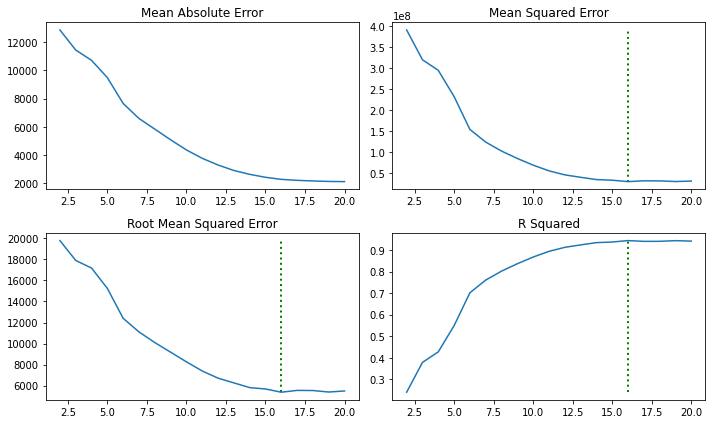

In [55]:
fig, axis = plt.subplots(nrows=2, ncols=2,figsize=(10,6))

# Multiple line plots
axis[0, 0].plot( 'N Depth', 'Mean Absolute Error', data=tree_results_depth)
axis[0, 0].set_title('Mean Absolute Error')

axis[0, 1].plot( 'N Depth', 'Mean Squared Error', data=tree_results_depth)
axis[0, 1].set_title('Mean Squared Error')
axis[0, 1].vlines(x=n_mse, 
                          ymin=tree_results_depth['Mean Squared Error'].min(), 
                          ymax=tree_results_depth['Mean Squared Error'].max(), 
                          colors='green', 
                          ls=':', 
                          lw=2)

axis[1, 0].plot( 'N Depth', 'Root Mean Squared Error', data=tree_results_depth)
axis[1, 0].set_title('Root Mean Squared Error')
axis[1, 0].vlines(x=n_rmse, 
                          ymin=tree_results_depth['Root Mean Squared Error'].min(), 
                          ymax=tree_results_depth['Root Mean Squared Error'].max(), 
                          colors='green', 
                          ls=':', 
                          lw=2)

axis[1, 1].plot( 'N Depth', 'R Squared', data=tree_results_depth)
axis[1, 1].set_title('R Squared')
axis[1, 1].vlines(x=n_rs, 
                          ymin=tree_results_depth['R Squared'].min(), 
                          ymax=tree_results_depth['R Squared'].max(), 
                          colors='green', 
                          ls=':', 
                          lw=2)

# Pack all the plots and displaying them
plt.tight_layout()
plt.show()

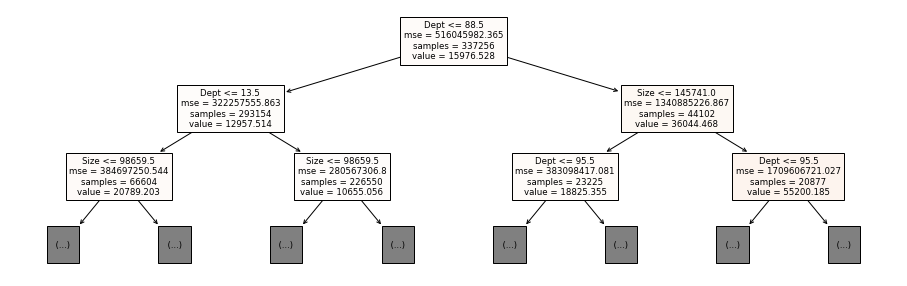

In [56]:
# Decision tree visualization
fig = plt.figure(figsize=(16,5))
_ = tree.plot_tree(tree_r, feature_names=X_train.columns, max_depth=2, filled=True)

<center>
    --<br>
    <strong>
        Set max_depth to 8 to prevent overfitting. Re-run the model
    </strong>
    <br>--
</center>

In [57]:
# Define predictors
predictors = list(set(reg_df.columns) - set(['WeeklySales']))

# Split dataset in features and target variable
y = reg_df['WeeklySales']
X = reg_df[predictors]

# Split 80% of the data to the training set while 20% of the data to test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Perform the regression tree model
tree_r = DecisionTreeRegressor(max_depth=8, random_state=0)
tree_r.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, random_state=0)

In [58]:
# Calculate predicted y value based on the model created above
y_pred_tree = tree_r.predict(X)

# Add a new column for Decision Tree predictions
pred_df['DecisionTree'] = y_pred_tree.tolist()

##### [Back to Top](#Top)

### 4.4 Regression Tree in Random Forests<a id=4.4></a>

In [59]:
# Define predictors
predictors = list(set(reg_df.columns) - set(['WeeklySales']))

# Split dataset in features and target variable
y = reg_df['WeeklySales']
X = reg_df[predictors]

# Split 80% of the data to the training set while 20% of the data to test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [60]:
# Run the model
rf = RandomForestRegressor(random_state=0, n_estimators=10)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [61]:
# Calculate predicted y value based on the model created above
y_pred_rf = rf.predict(X_test)

In [62]:
# Capture the statistical measures to measure the model's performance
rf_results = pd.DataFrame({'Mean Absolute Error': metrics.mean_absolute_error(y_test, y_pred_rf),
                                            'Mean Squared Error': metrics.mean_squared_error(y_test, y_pred_rf),
                                            'Root Mean Squared Error': np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)),
                                            'R Squared': rf.score(X_test,y_test)},
                                            index=['Random Forest'])
rf_results

,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R Squared
Random Forest,1746.422307,1.905763e+07,4365.504878,0.96298


In [63]:
# Calculate predicted y value based on the model created above
y_pred_rf = rf.predict(X)

# Add a new column for Random Forest predictions
pred_df['RandomForest'] = y_pred_rf.tolist()

##### [Back to Top](#Top)

---
## 5. Compare Model<a id=5></a>

In [64]:
pred_df.head()

,Store,Dept,Date,Actual,SKLearn,Statsmodels,DecisionTree,RandomForest
0,1,1,2010-05-02,24924.50,12621.010660,12641.387462,24705.344321,27845.088
1,1,1,2010-12-02,46039.49,13313.066436,13457.998252,24705.344321,33890.677
2,1,1,2010-02-19,41595.55,11741.565886,11707.614805,24705.344321,42120.582
3,1,1,2010-02-26,19403.54,11790.075344,11681.885779,24705.344321,19435.095
4,1,1,2010-05-03,21827.90,12602.803160,12547.419155,24705.344321,22206.526


In [65]:
# Get the data from Store #1 and Dept #1 to do a model comparison
pred_df_1 = pred_df[(pred_df['Store']==1)&(pred_df['Dept']==1)].reset_index()
pred_df_1 = pred_df_1[['Date','Actual','SKLearn','Statsmodels','DecisionTree','RandomForest']]
pred_df_1.sort_values(by='Date', inplace=True, ignore_index=True)
pred_df_1.head()

,Date,Actual,SKLearn,Statsmodels,DecisionTree,RandomForest
0,2010-01-10,20094.19,12753.053729,12588.443871,18197.472630,22867.777
1,2010-02-04,57258.43,12745.388394,12513.952571,24705.344321,45905.977
2,2010-02-07,16333.14,13201.733684,12983.010007,18197.472630,16750.101
3,2010-02-19,41595.55,11741.565886,11707.614805,24705.344321,42120.582
4,2010-02-26,19403.54,11790.075344,11681.885779,24705.344321,19435.095


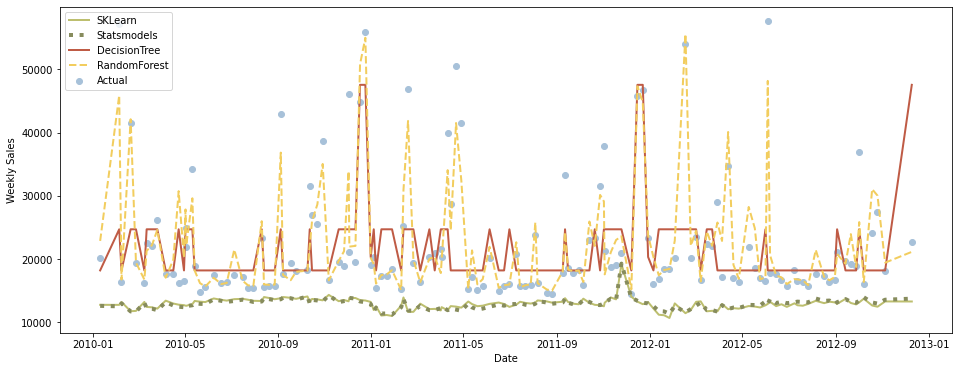

In [66]:
# Display actual values and predictions
plt.figure(figsize=(16,6))

plt.scatter('Date', 'Actual', data=pred_df_1, color='#A7C1D9')
plt.plot('Date', 'SKLearn', data=pred_df_1, color='#BDBF6F', linestyle='-', linewidth=2)
plt.plot('Date', 'Statsmodels', data=pred_df_1, color='#878C5D', linestyle=':', linewidth=4)
plt.plot('Date', 'DecisionTree', data=pred_df_1, color='#BF5B45', linestyle='-',linewidth=2)
plt.plot('Date', 'RandomForest', data=pred_df_1, color='#F2CD5E', linestyle='--',linewidth=2)

plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

<center>
    --<br>
    <strong>
        Compared to linear regression, regression tree models, especially Random Forest, were better at forecasting sales.<br>
        The model must be further tested to determine whether excessive overfitting has occurred.
    </strong>
    <br>--
</center>

##### [Back to Top](#Top)